# XGBoost Models for Study 3

In [45]:
from matplotlib import pyplot 
from numpy import mean
from numpy import std
from sklearn.calibration import CalibratedClassifierCV as CCCV
from sklearn.calibration import calibration_curve
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix as confusion
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score as ppv
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import recall_score as recall
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
import itertools
import joblib
import numpy as np
import pandas as pd
import pip
from xgboost import XGBClassifier as xgb
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [15]:
clf=xgb(random_state=26, n_jobs=-1, scale_pos_weight=25)
space=dict()
space['n_estimators']=[10, 100, 500, 1000]
space['max_depth']=[3, 6, 9, 12]
space['eta']=[0.001, 0.01, 0.1, 0.3, 1]
space['colsample_bytree']=[0.1, 0.2, 0.4, 0.6, 0.8, 1.0]
space['subsample']=[0.1, 0.2, 0.4, 0.6, 0.8, 1.0]
space['scale_pos_weight']=[1, 10, 20, 25, 30, 50]

searchXGB=RandomizedSearchCV(clf, space, scoring='roc_auc', n_jobs=-1, n_iter=100, refit=True)

### Suicidal ideation Models

In [17]:
Xi=pd.read_csv(r'C:\Users\z5291979\OneDrive - UNSW\Documents\lsac-data\processed_data\Xi.csv')
Xi_hold=pd.read_csv(r'C:\Users\z5291979\OneDrive - UNSW\Documents\lsac-data\processed_data\Xi_hold.csv')
y=pd.read_csv(r'C:\Users\z5291979\OneDrive - UNSW\Documents\lsac-data\processed_data\y_si.csv')
y_hold_si=pd.read_csv(r'C:\Users\z5291979\OneDrive - UNSW\Documents\lsac-data\processed_data\y_hold_si_si.csv')


In [18]:
Xi.shape
Xi_hold.shape
y.shape
y_hold_si.shape

(1699, 1011)

(729, 1012)

(1699, 1)

(729, 1)

In [28]:
#Getting rid of unnamed column- this often occurs after csv is read with the index from excel

Xi_hold= Xi_hold.drop('Unnamed: 0', axis=1)

In [19]:
searchXGB.fit(Xi, y)
searchXGB.best_params_

RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None...
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=-1,
                                           num_parallel_tree=None,
                                           random_state=26, ...),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.1, 0.2, 0.4, 0.6,
                                                             0.8, 1.0],
                                        'eta': [0.001, 0.01, 0.1, 0.3, 1],
                                        'max_depth': [3, 6, 9, 12],
                                        'n_estimators': [10, 100, 500, 1000],
                                        'scale_pos_weight': [1, 10, 20, 25, 30,
                                                             50],
                                        'subsample': [0.1, 0.2, 0.4, 0.6, 0.8,
                                                      1.0]},
                   scoring='roc_auc')

{'subsample': 0.6,
 'scale_pos_weight': 1,
 'n_estimators': 1000,
 'max_depth': 12,
 'eta': 0.01,
 'colsample_bytree': 0.1}

In [20]:
cXGB=CCCV(searchXGB.best_estimator_, method='isotonic')
cXGB.fit(Xi, y)
joblib.dump(searchXGB.best_estimator_, 'XGB_si_Uncalibrated.sav')
joblib.dump(cXGB, 'XGB_si.sav')

c:\Users\z5291979\OneDrive - UNSW\Documents\lsac-data\lsac-suicidality\.venv\lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


CalibratedClassifierCV(estimator=XGBClassifier(base_score=None, booster=None,
                                               callbacks=None,
                                               colsample_bylevel=None,
                                               colsample_bynode=None,
                                               colsample_bytree=0.1,
                                               device=None,
                                               early_stopping_rounds=None,
                                               enable_categorical=False,
                                               eta=0.01, eval_metric=None,
                                               feature_types=None, gamma=None,
                                               grow_policy=None,
                                               importance_type=None,
                                               interaction_constraints=None,
                                               learning_rate=None, max_bin=None,
                                               max_cat_threshold=None,
                                               max_cat_to_onehot=None,
                                               max_delta_step=None,
                                               max_depth=12, max_leaves=None,
                                               min_child_weight=None,
                                               missing=nan,
                                               monotone_constraints=None,
                                               multi_strategy=None,
                                               n_estimators=1000, n_jobs=-1,
                                               num_parallel_tree=None, ...),
                       method='isotonic')

['XGB_si_Uncalibrated.sav']

['XGB_si.sav']

In [23]:
#Creating function that predicts probabilities using the calibrated model
def predict(data):
    proba=cXGB.predict_proba(data)
    proba=proba[:, 1]
    print('Probs: %.3f (%.3f)' % (mean(proba), std(proba)) )

    return proba

In [52]:
si_trainprob=predict(Xi)
si_testprob=predict(Xi_hold)


Probs: 0.164 (0.272)
Probs: 0.125 (0.152)


In [39]:
#Creating a function which evaluates the model
def eval(y_hold, proba, thresh):
    ypred=np.where(proba>thresh, 1, 0)
    f1= f1_score(y_hold, ypred)
    print(f'F1= {f1:f}')
    sens= recall(y_hold, ypred)
    print(f'Sensitivity= {sens:f}')
    tn, fp, fn, tp= confusion(y_hold, ypred).ravel()
    spec=tn/(tn+fp)
    print(f'Specificity= {spec:f}')
    auc= roc_auc_score(y_hold, proba)
    print(f'AUROC= {auc:f}')

    return ypred, f1, sens, spec, auc

In [40]:
ypred, f1, sens, spec, auc=eval(y_hold_si, si_testprob, 0.119263)

F1= 0.428954
Sensitivity= 0.833333
Specificity= 0.688784
AUROC= 0.831161


In [50]:
#Plotting function
def graphs(y_hold, testprob):
#ROC curve
    fpr, tpr, thresholds=roc_curve(y_hold, testprob)
    # plot the roc curve for the model 
    pyplot.plot([0,1], [0,1], linestyle='--', label='Baseline')
    pyplot.plot(fpr, tpr, marker='.', label='XGB')
    # axis labels
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    pyplot.legend()
    # show the plot
    pyplot.show()
#Calibration curve
    # reliability diagram
    fop, mpv = calibration_curve(y_hold, testprob, n_bins=10)
    # plot perfectly calibrated
    pyplot.plot([0, 1], [0, 1], linestyle='--')
    # plot model reliability
    pyplot.xlabel('Predicted probability')
    pyplot.ylabel('True probability')
    pyplot.plot(mpv, fop, marker='.')
    pyplot.show()
#Precision-recall curve
    precision, recall, thresholds = precision_recall_curve(y_hold, si_testprob)
    # plot the roc curve for the model
    y_hold=np.ravel(y_hold)
    no_skill = len(y_hold[y_hold==1]) / len(y_hold)
    pyplot.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
    pyplot.plot(recall, precision, marker='.', label='Logistic')
    # axis labels
    pyplot.xlabel('Recall')
    pyplot.ylabel('Precision')
    pyplot.legend()
    # show the plot
    pyplot.show()

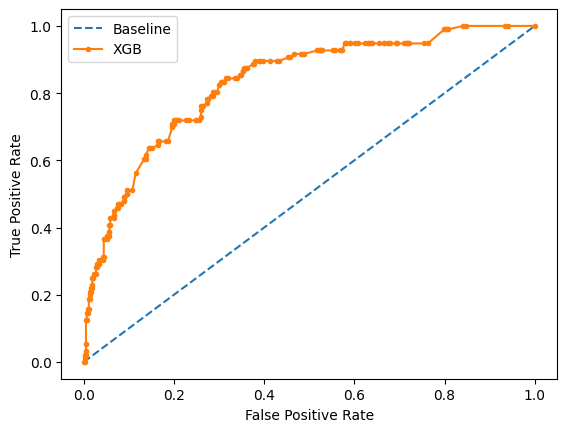

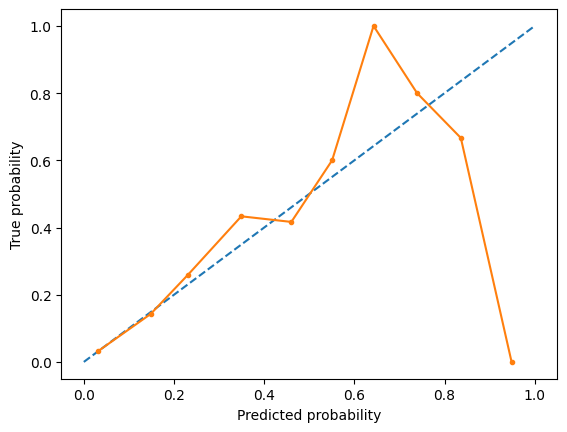

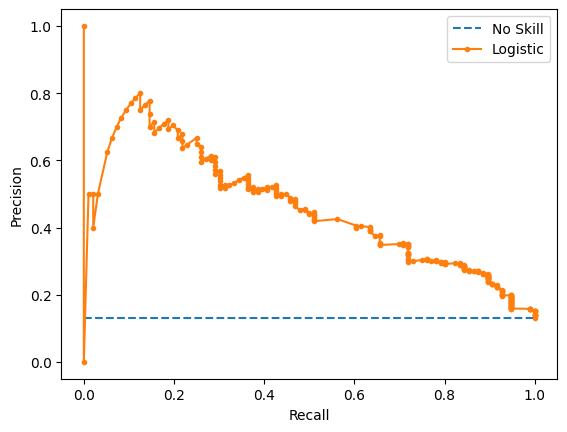

In [51]:
graphs(y_hold_si, si_testprob)